In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from tensorboardX import SummaryWriter
import tqdm
import os
import uuid
import random
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

unique_id = str(uuid.uuid4())

plot = plt.figure()

def weights_initialize(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
        module.bias.data.fill_(0.01)
        
class _TransModel(nn.Module):
    """ Model for DQN """

    def __init__(self, input_len, output_len):
        super(_TransModel, self).__init__()
        
        self.fc1 = nn.Sequential(
            torch.nn.Linear(input_len, 1024),
            torch.nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc1.apply(weights_initialize)
        
        self.fc2 = nn.Sequential(
            torch.nn.Linear(1024, 256),
            # torch.nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.fc2.apply(weights_initialize)
        
        self.output_layer = nn.Sequential(
            torch.nn.Linear(256, output_len)
        )
        self.output_layer.apply(weights_initialize)
        
    def forward(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        
        return self.output_layer(x)

class TransModel():
    def __init__(self, input_len, ouput_len, learning_rate = 0.0001):
        self.model = _TransModel(input_len, ouput_len)
        
        if use_cuda:
            print("Using GPU")
            self.model = self.model.cuda()
        else:
            print("Using CPU")
        self.steps = 0
        # self.model = nn.DataParallel(self.model)
        self.optimizer = Adam(self.model.parameters(), lr = learning_rate)
        self.loss_fn = nn.MSELoss(reduction='mean')
        
        self.steps = 0
        
    def predict(self, input, steps, learning):
        
        output = self.model(input).squeeze(1)
        #reward, next_state = output[0], output[1:]

        return output

    def predict_batch(self, input):
        output = self.model(input)
        #reward, next_state = output[:, 0], output[:, 1:]
        return output

    def fit(self, state, target_state):
        loss = self.loss_fn(state, target_state)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.steps += 1
        return loss
    
    def save(self):
        file_path = './models_mb/NEXUS_MODEL.8.10.19.pt'
        torch.save(self.model.state_dict(), file_path)

In [2]:
def dot_plot(x, y, fig, style = 'o'):
    x = x * 2000
    y = y * 2000
    legend = [
                "Match line",
                "Player 1 Top HP",
                "Player 1 Bottom HP",
                "Player 2 Top HP",
                "Player 2 Bottom HP",
             ]
    fig=plt.figure(figsize=(15, 15), dpi= 160, facecolor='w', edgecolor='k')

    ax = plt.subplot(111)
    ax.set_ylim([-100,2100])
    ax.set_xlim([-100,2100])
    ax.plot(list(range(-100, 2100)),list(range(-100,2100)), "b--", alpha=0.05)
    for i in range(len(legend) - 1):
        #plt.plot(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(), style, s = 0.1)
        ax.scatter(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(),s = 0.5)

    plt.title('Ground Truth - Predict of Units')
    plt.legend(legend, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Predict")
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
    ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.8), shadow=True, ncol=1)

    return plt

In [3]:
data = torch.load('all_experiences.pt')
np.set_printoptions(suppress=True)
l = len(data)

for i in range(0, len(data)):
    data[i][1] = [ data[i][1][63] / 2000 , data[i][1][64] / 2000 , data[i][1][65] / 2000 , data[i][1][66] / 2000 ]
    
    data[i][0][0:4] = np.true_divide( data[i][0][0:4], 30) # Normalize P1 top buildings
    data[i][0][5:9] = np.true_divide( data[i][0][5:9], 30) # Normalize P2 top buildings
    
    data[i][0][0:4] = np.true_divide( data[i][0][0:4], 30) # Normalize P1 bottom buildings
    data[i][0][5:9] = np.true_divide( data[i][0][5:9], 30) # Normalize P2 bottom buildings
    
    data[i][0][63] = data[i][0][63] / 2000 # Normalize P1 Top Nexus HP
    data[i][0][64] = data[i][0][64] / 2000 # Normalize P2 Top Nexus HP
    
    data[i][0][65] = data[i][0][65] / 2000 # Normalize P1 Bottom Nexus HP
    data[i][0][66] = data[i][0][66] / 2000 # Normalize P2 Bottom Nexus HP

    data[i][0][0] = data[i][0][10] / 1500 # Normalize P1 Minerals

np.random.shuffle(data)

train_data = np.array(data[: int(np.floor(l * 0.8))])
test_data = np.array(data[int(np.floor(l * 0.8)) : ])

print(train_data.shape, test_data.shape)

batch_size = 128
summary_test = SummaryWriter(log_dir = 'nexus-HP-transition-model-report-predict-4/')

(79200, 2) (19800, 2)


In [4]:
baseline = np.stack(test_data[:, 0])
idx = [63, 64, 65, 66]
baseline_hp = baseline[:, idx]

bl_next_state_reward = np.stack(test_data[:, 1])

mse_baseline = ((baseline_hp - bl_next_state_reward)**2).mean(axis=None)
print(mse_baseline)

0.007540031518308081


In [5]:
def evaluation(model, data, epoch):
    state_action = torch.from_numpy(np.stack(data[:, 0])).type(FloatTensor)
    next_state_reward = torch.from_numpy(np.stack(data[:, 1])).type(FloatTensor)
    
    model.model.eval()
    criterion = nn.MSELoss(reduction='mean')
    
    outputs = model.predict_batch(state_action)

    mse = criterion(outputs, next_state_reward)
    mse_p1_top = criterion(outputs[:, 0], next_state_reward[:, 0])
    mse_p1_bottom = criterion(outputs[:, 1], next_state_reward[:, 1])
    mse_p2_top = criterion(outputs[:, 2], next_state_reward[:, 2])
    mse_p2_bottom = criterion(outputs[:, 3], next_state_reward[:, 3])

    accuracy = torch.sum( torch.sum( torch.eq( outputs, next_state_reward ) )).item()
    accuracy = accuracy / (2 * outputs.size()[0])

    if epoch % 1000 == 0:
        p = dot_plot(next_state_reward, outputs, plot)
        p.show()
    model.model.train()
    
    summary_test.add_scalar("MSE", float(mse.item()), epoch)
    summary_test.add_scalars("MSE",{'Baseline Nexus HP MSE': float(mse_baseline)}, epoch)

    summary_test.add_scalars("MSE",{'Player 1 Top Nexus HP MSE': float(mse_p1_top.item())}, epoch)
    summary_test.add_scalars("MSE",{'Player 1 Bottom Nexus HP MSE': float(mse_p1_bottom.item())}, epoch)
    
    summary_test.add_scalars("MSE",{'Player 2 Top Nexus HP MSE': float(mse_p2_top.item())}, epoch)
    summary_test.add_scalars("MSE",{'Player 2 Bottom Nexus HP MSE': float(mse_p2_bottom.item())}, epoch)
   
    f = open("nexus-HP-transition-model-report/test_loss.txt", "a+")
    f.write("loss:" + str(mse.item()) + ", ")
    f.write("acc:" + str(accuracy) + "\n")
    if epoch % 1000 == 0:
        f.write("output:" + str(outputs[0:2]) + "\n")
        f.write("ground true:" + str(next_state_reward[0:2]) + "\n")
    f.close()
    return mse.item()

In [6]:
#check_model = TransModel(len(data[0][0]), len(data[0][1]))

#check_model.model.load_state_dict(torch.load('./models_mb/NEXUS_MODEL.8.9.19.pt'))

#evaluation(check_model, test_data, 0)

In [7]:
trans_model = TransModel(len(data[0][0]), len(data[0][1]))

Using GPU


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([79200, 68]) torch.Size([79200, 4])


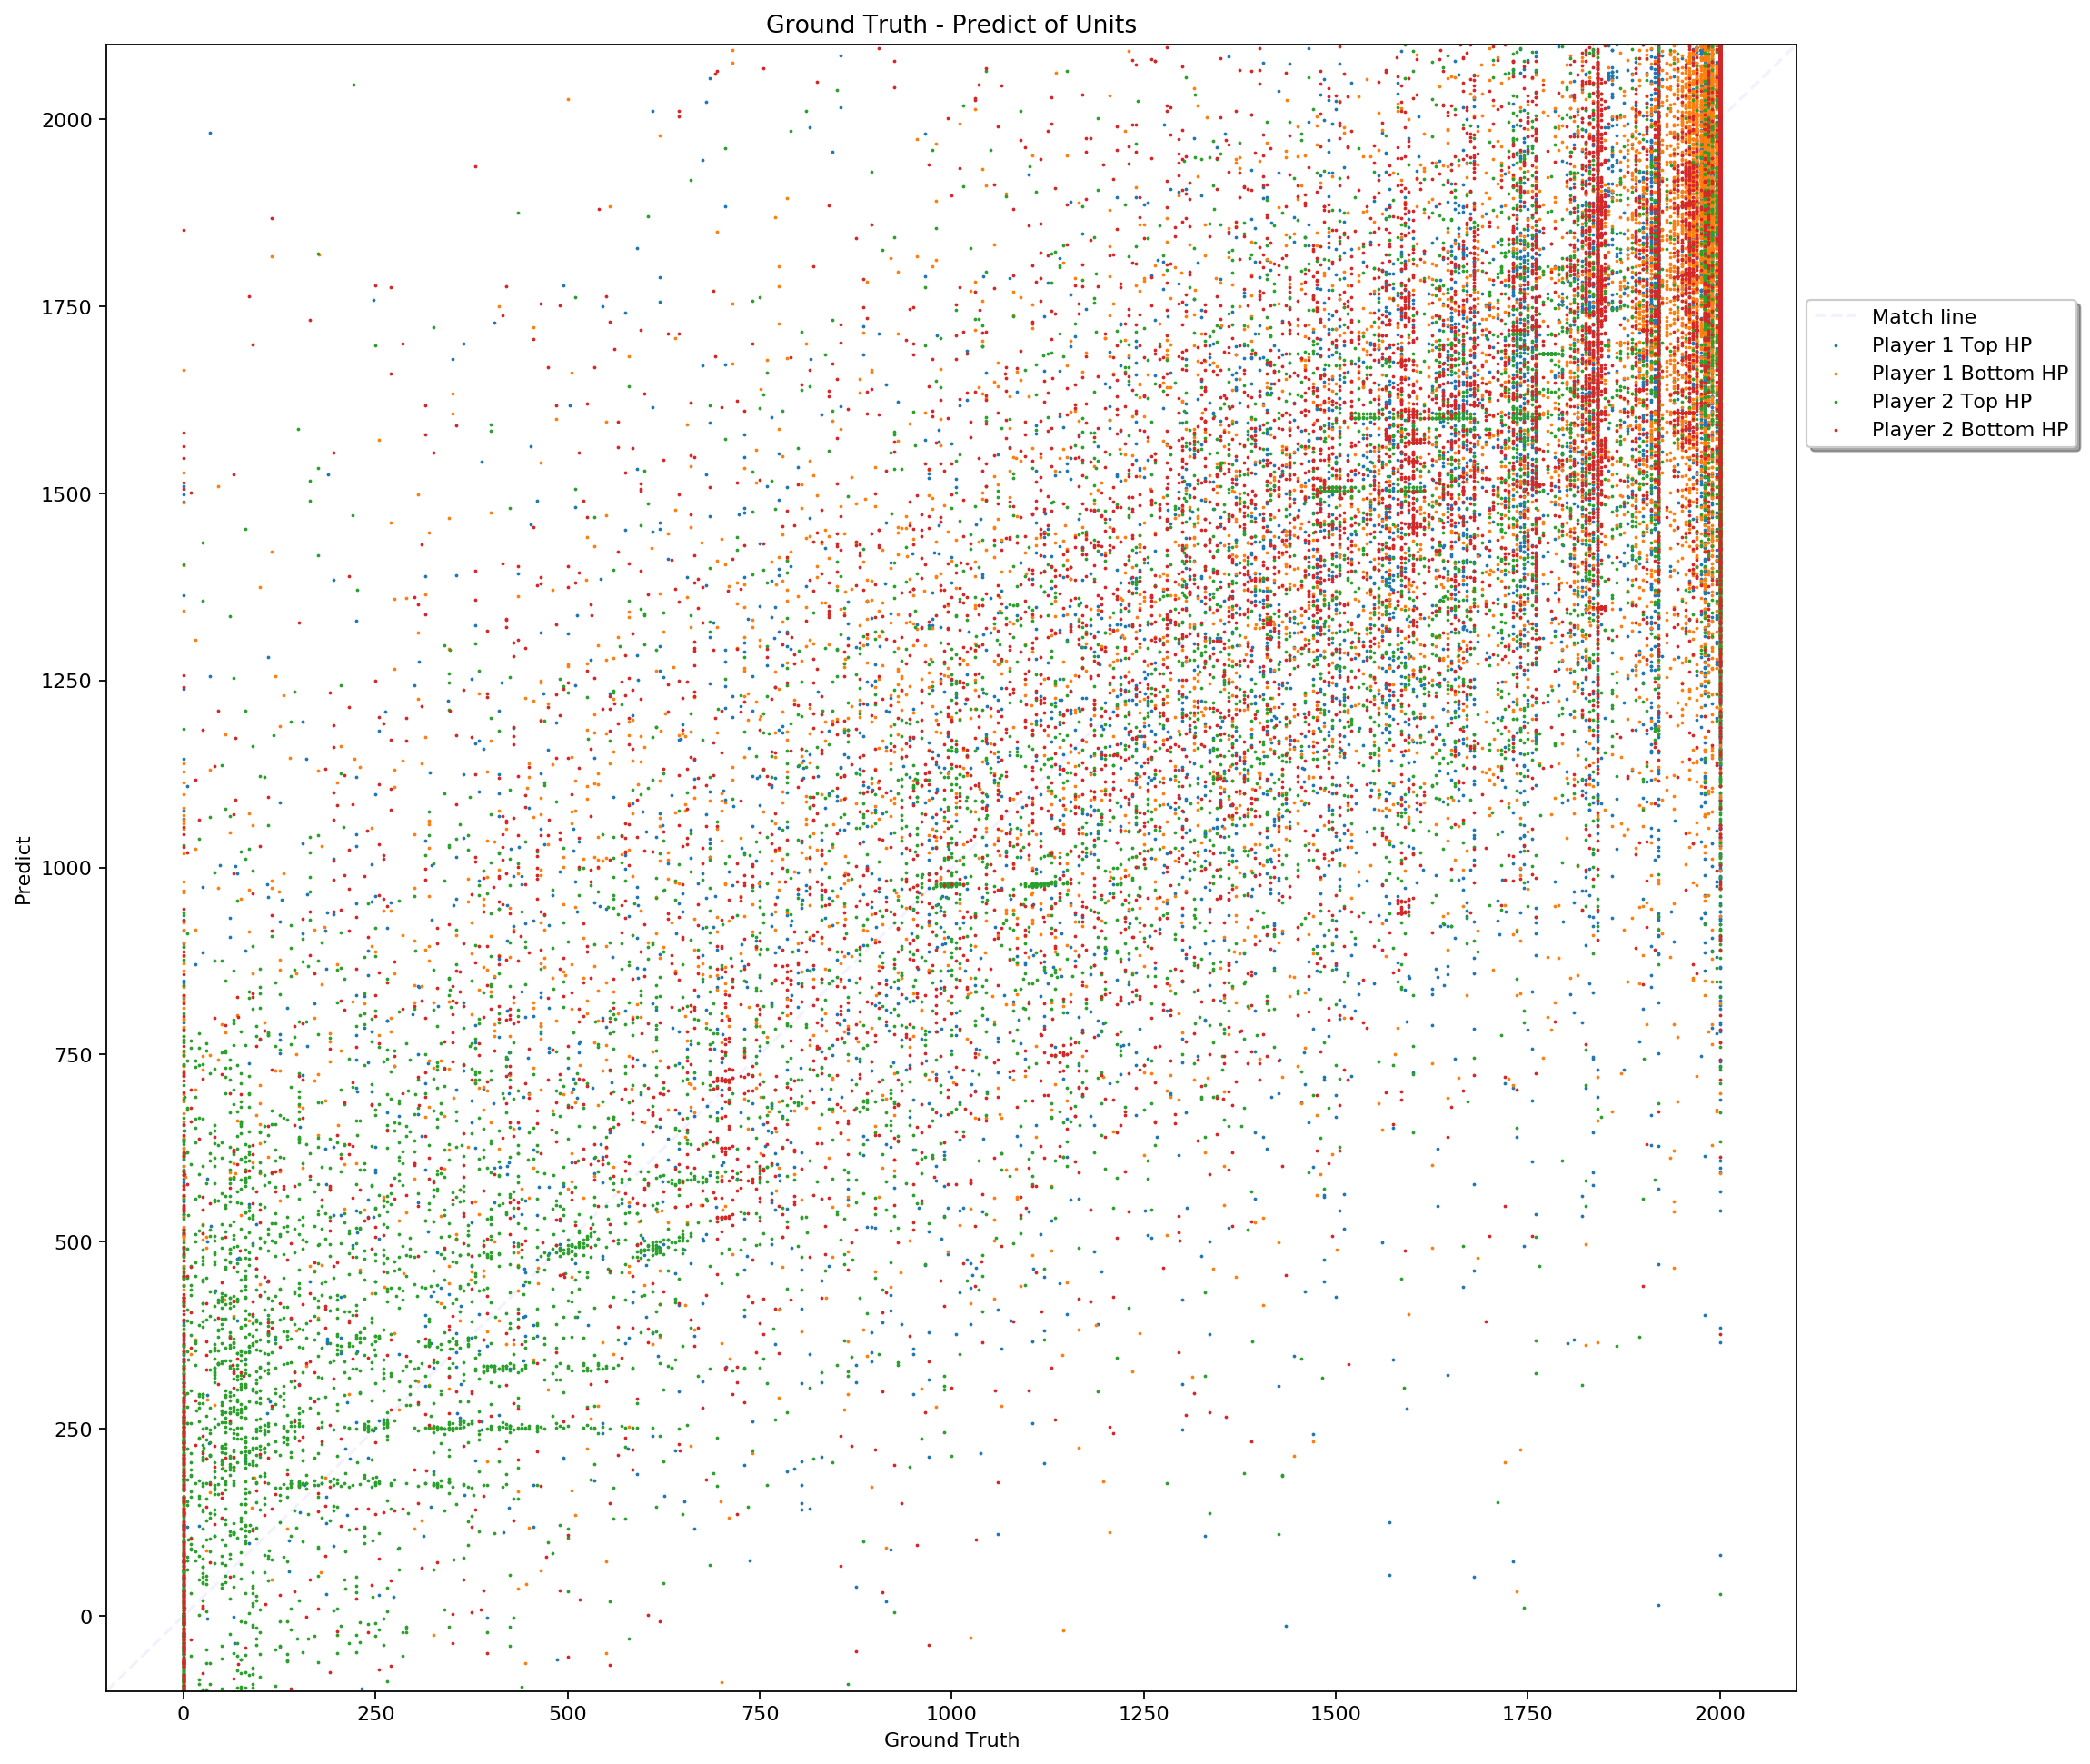

  1%|          | 86/10000 [05:15<10:49:24,  3.93s/it]

In [ ]:

state_action = torch.from_numpy(np.stack(train_data[:, 0])).type(FloatTensor)
next_state_reward = torch.from_numpy(np.stack(train_data[:, 1])).type(FloatTensor)
print(state_action.size(), next_state_reward.size())

for epoch in tqdm.tqdm(range(10000)):
    loss = 0
    s = np.arange(state_action.shape[0])
    np.random.shuffle(s)
    train_x = state_action[s]
    train_y = next_state_reward[s]
    for i in range(state_action.shape[0] // batch_size + 1):
        if (i + 1) * batch_size <= state_action.shape[0]:
            start = i * batch_size
            end = (i + 1) * batch_size
        elif i * batch_size != state_action.shape[0]:
            start = i * batch_size
            end = state_action.shape[0]
        else:
            continue
            
        #print(start, end)
        inputs, ground_true = train_x[start : end, :], train_y[start : end, :]
       # print(inputs.size())
       # print(ground_true.size())
        outputs = trans_model.predict_batch(inputs)
        loss += trans_model.fit(outputs, ground_true)
#     print(epoch)
    summary_test.add_scalars("MSE",{'Train MSE': float(loss / (state_action.shape[0] // batch_size + 1) )}, epoch)
    evaluation(trans_model, test_data, epoch)
    #break
    if epoch % 1000 == 0 and epoch != 0:
        print(epoch)
        trans_model.save()